In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import pdb
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
from mods import all_metric

from sklearn.metrics import mean_absolute_error, mean_squared_error
from ase import Atoms
from ase.io import Trajectory, read
import torch
import torchani
import warnings
import string
from datetime import datetime

device = "cuda"

## Create DART Model

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DART_Net(nn.Module):
    def __init__(self):
        super(DART_Net, self).__init__()
        self.fi1 = nn.Linear(769, 128)
        self.fi2 = nn.Linear(128, 128)
        self.fi3 = nn.Linear(128, 32)
        self.fi4 = nn.Linear(32, 1)
        
    def forward(self, ai):
#         pdb.set_trace()
        ai_sum = ai.sum(axis=2)
        same_shape = ai_sum.shape
        ones = torch.ones(same_shape, device=device)
        zeros = torch.zeros(same_shape, device=device)
        make_zero = torch.where(ai_sum==0, zeros, ones)
        ai_mask = make_zero.unsqueeze(dim=2)

        ######### atom_i ############
        ai = F.celu(self.fi1(ai), 0.1)
        ai = F.celu(self.fi2(ai), 0.1)
        ai = F.celu(self.fi3(ai), 0.1)
        ai = self.fi4(ai)
        ai = ai * ai_mask
        return ai

# # def set_aev_param():
# Rcr = 5.2000e+00
# Rca = 3.5000e+00

# EtaR = torch.tensor([1.6000000e+01], device=device)
# ShfR = torch.tensor([9.0000000e-01, 1.0193548e+00, 1.1387097e+00, 1.2580645e+00, 1.3774194e+00, 1.4967742e+00, 1.6161290e+00, 1.7354839e+00, 1.8548387e+00, 1.9741935e+00, 2.0935484e+00, 2.2129032e+00, 2.3322581e+00, 2.4516129e+00, 2.5709677e+00, 2.6903226e+00, 2.8096774e+00, 2.9290323e+00, 3.0483871e+00, 3.1677419e+00, 3.2870968e+00, 3.4064516e+00, 3.5258065e+00, 3.6451613e+00, 3.7645161e+00, 3.883871e+00, 4.0032258e+00, 4.1225806e+00, 4.2419355e+00, 4.3612903e+00, 4.4806452e+00, 4.6e+00], device=device)
# Zeta = torch.tensor([3.2000000e+01], device=device)
# ShfZ = torch.tensor([1.9634954e-01, 5.8904862e-01, 9.8174770e-01, 1.3744468e+00, 1.7671459e+00, 2.1598449e+00, 2.5525440e+00, 2.9452431e+00], device=device)
# EtaA = torch.tensor([8.0000000e+00], device=device)
# ShfA = torch.tensor([9.0000000e-01, 1.1785714e+00, 1.4571429e+00, 1.7357143e+00, 2.0142857e+00, 2.2928571e+00, 2.5714286e+00, 2.8500000e+00], device=device)
# num_species = 4

# aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)
# species_to_tensor = torchani.utils.ChemicalSymbolsToInts('HCNO')

# inttosymbol = {6:"C", 1:"H", 7:"N", 8:"O"}

# def corrected_sp_format(tmp_sp):
#     return species_to_tensor([inttosymbol[i] for i in tmp_sp])

In [3]:
device

'cuda'

## Load data, pre-process to generate descriptors (BPSF)

In [4]:
# valid_db = np.load("data/valid.npz", allow_pickle=True)
# test_db = np.load("data/test.npz", allow_pickle=True)
# train_db = np.load("data/train.npz", allow_pickle=True)

In [5]:
# all_data = {"va_db":valid_db, "te_db":test_db, "ta_db":train_db}
# energy = {}
# coor = {}
# atom_number = {}
# atom_counts = {}
# for k, v in all_data.items():
#     energy[k] = v["U0"]
#     coor[k] = v["positions"]
#     atom_number[k] = v["charges"]
#     atom_counts[k] = v["num_atoms"]

In [6]:
# aev_mat = []
# mol_ene = []
# mol_sp = []
# for i in range(len(energy["va_db"])):
#     try:
#         tmp_sp = corrected_sp_format(atom_number["va_db"][i,:atom_counts["va_db"][i]])
#         tmp_coor = coor["va_db"][i,:atom_counts["va_db"][i]]
#         # print(i, tmp_sp)
#         species = tmp_sp.unsqueeze(0)
#         coort = torch.FloatTensor(tmp_coor).unsqueeze(0)
#         result = aev_computer((species.to(device), coort.to(device))).aevs
#         aev_mat.append(result)
#         mol_ene.append(energy["va_db"][i])
#         mol_sp.append(atom_number["va_db"][i,:atom_counts["va_db"][i]])
#     except KeyError:
#         continue

## Save AEV as .npz file

In [7]:
# np.savez("valid_aev_mat.npz", aev=np.array(aev_mat), ene=mol_ene, sp=mol_sp)

## Read saved AEV and energy data to be fed into model

In [8]:
class custom_dataset(Dataset):
    def __init__(self, file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.data = np.load(file, allow_pickle=True)
        self.pad = pad_sequence([i.squeeze(0) for i in self.data["aev"]], batch_first=True).to("cpu")
        self.ener = torch.Tensor(self.data["ene"])
        self.tmp_sp = []
        for i in self.data["sp"]:
            self.tmp_sp.append(F.pad(torch.tensor(i), (0,29-len(i)), "constant", 0).unsqueeze(0))
#         pdb.set_trace()
        self.sp = torch.cat(self.tmp_sp, dim=0)
        self.pad_aevs = torch.cat((self.sp.unsqueeze(2), self.pad), 2)

#         self.sp = F.pad(b, (0,3-len(b)), "constant", 0) [i.reshape(1,-1) for i in self.data["sp"]], batch_first=True)
#         self.sp = pad_sequence([i.reshape(1,-1) for i in self.data["sp"]], batch_first=True)
        
    def __len__(self):
        return len(self.ener)
    
    def __getitem__(self, idx):
        sample = {"aev": self.pad_aevs[idx].to(device), "energy": self.ener[idx].to(device), "sp": self.sp[idx].to(device)}
        return sample

In [9]:
# data = np.load("test_aev_mat.npz", allow_pickle=True)
test_data = custom_dataset(file="test_aev_mat.npz")
valid_data = custom_dataset(file="valid_aev_mat.npz")

In [10]:
trainloader = DataLoader(valid_data, batch_size=32, shuffle=True)
validloader = DataLoader(test_data, batch_size=32, shuffle=True)

## Initialize Model, Define loss, optimizer

In [11]:
DART_model = DART_Net().to(device)

def init_params(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, a=1.0)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

DART_model.apply(init_params)

random_seed= 42
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(DART_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=25, verbose=True, eps=1e-09)

In [32]:
def all_metric(y_true, y_pred):
    y_true = y_true.cpu()
    y_pred = y_pred.cpu()
    print("RMSE = ", mean_squared_error(y_true, y_pred, squared=False))
    print("MAE = ", mean_absolute_error(y_true, y_pred))

    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, c='crimson')
    # plt.yscale('log')
    # plt.xscale('log')

    p1 = max(max(y_pred), max(y_true))
    p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()

## Training loop, which trains and validates after each epoch

In [33]:
epochal_train_losses = []
epochal_val_losses  = []
num_epochs = 1500
epoch_freq = 10

def test(DART_model, testloader):
    mae = torch.nn.L1Loss()
    rmse = torch.nn.MSELoss()
    pred_energy = torch.tensor([], device="cuda")
    real_energy = torch.tensor([], device="cuda")
    cluster_size = torch.tensor([], device="cuda")
    DART_model.eval()
    with torch.no_grad():
        for batch in testloader:
            energy = DART_model(batch["aev"])
            energy = energy.sum(axis=1).squeeze(dim=1)
            pred_energy = torch.cat((pred_energy, energy))
            real_energy = torch.cat((real_energy, batch["energy"]))
            cluster_size = torch.cat((cluster_size, batch["aev"][:,0].sum(axis=1)))
        results = torch.stack((cluster_size, real_energy, pred_energy), axis=1)
        test_loss = mae(pred_energy, real_energy)
        rmse_loss = torch.sqrt(rmse(pred_energy, real_energy))
        print("Test MAE = ", test_loss.item(), "Test RMSE = ", rmse_loss.item())
        all_metric(real_energy, pred_energy)
        return results, test_loss, rmse_loss
    
def train(DART_model, optimizer, epochal_train_losses, criterion):
    train_loss = 0.00
    n = 0
    DART_model.train()
    for batch in trainloader:
#         pdb.set_trace()
        optimizer.zero_grad()
        energy = DART_model(batch["aev"])
#         print(energy.shape)
        energy = energy.sum(axis=1)
        batch_loss = criterion(energy, batch["energy"].unsqueeze(dim=1))
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.detach().cpu()
        n += 1
    train_loss /= n
    epochal_train_losses.append(train_loss)

def train_and_evaluate(DART_model, optimizer, scheduler, criterion, start_epoch=1, restart=None):
    if restart:
        restore_path = os.path.join(log_dir + "/last.pth.tar")
        checkpoint = load_checkpoint(restore_path, DART_model, optimizer)
        start_epoch = checkpoint["epoch"]

    best_val = 100000.00
    early_stopping_learning_rate = 1.0E-8
    
    for epoch in range(1, num_epochs+1):
        learning_rate = optimizer.param_groups[0]['lr']
        if learning_rate < early_stopping_learning_rate:
            break

        ############ training #############
        train(DART_model, optimizer, epochal_train_losses, criterion)
        
        ############ validation #############
        n=0
        val_loss = 0.0
        DART_model.eval()
        for batch in validloader:
            energy = DART_model(batch["aev"])
            energy = energy.sum(axis=1)
            batch_loss = criterion(energy, batch["energy"].unsqueeze(dim=1))
            val_loss += batch_loss.detach().cpu()
            n += 1
        val_loss /= n
        epochal_val_losses.append(val_loss)
        scheduler.step(val_loss)
     
        is_best = val_loss <= best_val
        if epoch % epoch_freq == 0:
            print("Epoch: {: <5} Train: {: <20} Val: {: <20}".format(epoch, epochal_train_losses[-1], val_loss))

## Let's start training

In [13]:
train_and_evaluate(DART_model, optimizer, scheduler, criterion)

Epoch: 10    Train: 1.866277813911438    Val: 1.6151621341705322  
Epoch: 20    Train: 1.9423669576644897   Val: 2.5103907585144043  
Epoch: 30    Train: 1.3907235860824585   Val: 1.399135708808899   
Epoch: 40    Train: 1.3466105461120605   Val: 1.0137733221054077  
Epoch: 50    Train: 1.2944533824920654   Val: 0.6149494051933289  
Epoch: 60    Train: 1.5084160566329956   Val: 1.73054838180542    
Epoch: 70    Train: 1.1773582696914673   Val: 1.3943172693252563  
Epoch: 80    Train: 1.2351853847503662   Val: 1.1028813123703003  
Epoch    85: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 90    Train: 0.28671136498451233  Val: 0.3108008801937103  
Epoch: 100   Train: 0.27106496691703796  Val: 0.2588624358177185  
Epoch: 110   Train: 0.2543846666812897   Val: 0.24889810383319855 
Epoch: 120   Train: 0.24331453442573547  Val: 0.23761267960071564 
Epoch: 130   Train: 0.22446970641613007  Val: 0.25266122817993164 
Epoch: 140   Train: 0.2188691794872284   Val: 0.2699514627456665  


## Testing the model on unseen data (test-set)

Test MAE =  0.12448915094137192 Test RMSE =  0.19080029428005219
RMSE =  0.1908003
MAE =  0.12448915


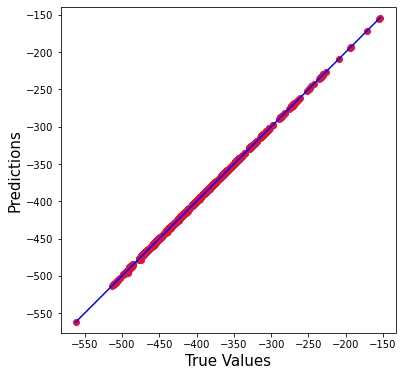

In [34]:
results, test_mae, test_rmse = test(DART_model, validloader)
# results, test_mae, test_rmse = test(DART_model, testloader)

## Training and validation loss curves

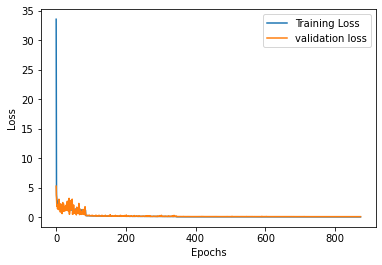

In [16]:
plt.plot(np.arange(0, len(epochal_train_losses), 1), epochal_train_losses, label='Training Loss')
plt.plot(np.arange(0, len(epochal_train_losses), 1), epochal_val_losses, label='validation loss')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

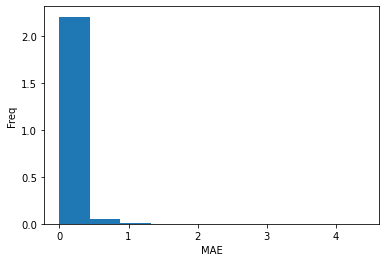

In [17]:
results = results[results[:,0].argsort()].cpu().numpy()
plt.hist(abs(results[:,1]-results[:,2]), density=True)
plt.xlabel("MAE")
plt.ylabel("Freq")
plt.show()